# Обучение

Здесь все свои телодвижения я делаю в коллабе, потому что пакет `gluonts`, как оказалось, на винде проблематично установить, чтобы не словить проблему с зависимостями (устанавливаются какие-то древние версии библиотек).

Но даже здесь на GPU установить не удалось.

In [1]:
!pip install -q gluonts[mxnet]

## Подготовка

In [2]:
import pandas as pd
import numpy as np
import mxnet as mx

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style('whitegrid')
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = 10, 5
plt.rcParams['legend.frameon'] = True
# palette = sns.color_palette('Set1')
# sns.set_palette(palette)

In [4]:
SEED = 10
mx.random.seed(SEED)
np.random.seed(SEED)

In [5]:
import pandas as pd
df = pd.read_csv('data/train_data.csv')
df_calendar = pd.read_csv('data/calendar.csv')
df_price = pd.read_csv('data/price_series.csv').drop('wm_yr_wk', axis=1)

In [6]:
df.date = pd.to_datetime(df.date, infer_datetime_format=True)
df_calendar.date = pd.to_datetime(df_calendar.date, infer_datetime_format=True)

In [7]:
df

,24957,24958,24959,24960,24961,24962,24963,24964,24965,24966,...,date,year,weekday,month,is_Cultural,is_National,No_holiday,is_Religious,is_Sporting,is_Christmas
0,0,1,0,1,2,1,0,0,0,0,...,2012-06-12,2012,2,6,0,0,0,0,1,0
1,0,0,0,2,1,0,0,1,0,0,...,2012-06-13,2012,3,6,0,0,1,0,0,0
2,0,0,0,0,1,0,0,2,0,0,...,2012-06-14,2012,4,6,0,0,1,0,0,0
3,1,0,0,0,1,2,0,0,0,0,...,2012-06-15,2012,5,6,0,0,1,0,0,0
4,0,3,0,0,3,0,0,0,0,0,...,2012-06-16,2012,6,6,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1436,2,0,1,0,0,0,2,1,0,1,...,2016-05-18,2016,3,5,0,0,1,0,0,0
1437,3,1,1,0,1,0,3,0,1,3,...,2016-05-19,2016,4,5,0,0,1,0,0,0
1438,0,0,2,0,1,0,3,0,0,1,...,2016-05-20,2016,5,5,0,0,1,0,0,0
1439,1,1,0,0,2,0,2,2,0,1,...,2016-05-21,2016,6,5,0,0,1,0,0,0


Схема данных простая: индекс -- индексы дня а-ля `d_num`, но в числовом виде, все по порядку. Таким образом, сами наблюдаения -- это строки. Столбцы -- товары и некоторые признаки.

In [8]:
df = df.set_index('date')

In [9]:
time_features = ['year', 'weekday', 'month']
cat_features = ['is_Cultural', 'is_National', 'No_holiday',	'is_Religious',	'is_Sporting', 'is_Christmas']
features_df = df[time_features + cat_features]
dates = df.index.to_numpy()
df = df.reset_index().drop(time_features + cat_features + ['date'], axis=1).T

In [10]:
df.index = df.index.astype(int)
df_price.columns = df_price.columns.astype(int)
df.index, df_price.columns

(Int64Index([24957, 24958, 24959, 24960, 24961, 24962, 24963, 24964, 24965,
             24966,
             ...
             25994, 25995, 25996, 25997, 25998, 25999, 26000, 26001, 26002,
             26003],
            dtype='int64', length=1047),
 Int64Index([24957, 24958, 24959, 24960, 24961, 24962, 24963, 24964, 24965,
             24966,
             ...
             25994, 25995, 25996, 25997, 25998, 25999, 26000, 26001, 26002,
             26003],
            dtype='int64', length=1047))

Теперь индекс здесь -- это метки товаров, столбцы -- таймстепы значений ряда. Признаки выделены в отдельный фрейм.

Разобьем данные на трейн и валидацию. В соревновании предполагалось делать прогноз на 28 дней -- таков наш горизонт прогнозирования.

На что я потратил очень много времени -- брал размер валидации равный размеру горизонта прогнозирования. В этом случае все предикты всегда были нулями. Поэтому берем размер валидации побольше (так уж устроено предсказание модели, прямо в статье об этом моменте сказано).

In [11]:
T = 28
val_size = T + 1
df_train = df.iloc[:, :-val_size]
df_valid = df.iloc[:, -val_size:]

tmp_feat_df = features_df.reset_index().drop('date', axis=1)

features_train = tmp_feat_df.iloc[:-val_size][cat_features]
features_valid = tmp_feat_df.iloc[-val_size:][cat_features]

prices_train = df_price.iloc[:-val_size].T
prices_valid = df_price.iloc[-val_size:].T

print('data shapes:', df_train.shape, df_valid.shape)
print('features shapes:', features_train.shape, features_valid.shape)
print('prices shapes:', prices_train.shape, prices_valid.shape)

data shapes: (1047, 1412) (1047, 29)
features shapes: (1412, 6) (29, 6)
prices shapes: (1047, 1412) (1047, 29)


In [12]:
freq = '1D'
start_train = pd.Period(dates[0], freq=freq)
start_valid = pd.Period(dates[-val_size], freq=freq)

Построим датасеты.

`feat_dynamic_cat` -- это категориальные признаки (для каждого ряда они одни и те же). Где-то их используют как `feat_dynamic_real`, причем скорее всего это обосновано тем, что в конфигурации модели нет аргумента `feat_dynamic_cat`. Да и почему бы и нет, они же все равно уже приведены в бинарный числовой вид.

Кроме того, здесь ничего не ограничивает нас от использования числового признака цены.

In [13]:
def get_item_feats(df, prices, index):
    # add price series feature to cats
    _ = pd.concat((features_train,prices_train.loc[index]), axis=1)
    return _.to_numpy().T

In [14]:
from gluonts.dataset.common import ListDataset

N = df.shape[0] # num series

train_ds = ListDataset(
       [{
            'target': df_train.iloc[i],
            'start': start_train,
            'item_id': str(df_train.iloc[i].name),
            'feat_static_cat': [df_train.iloc[i].name],
            'feat_dynamic_real': get_item_feats(features_train,
                                                prices_train,
                                                df_train.iloc[i].name),
        } for i in range(N)],

   freq=freq,
)

valid_ds = ListDataset(
       [{
            'target': df_valid.iloc[i],
            'start': start_valid,
            'item_id': str(df_valid.iloc[i].name),
            'feat_static_cat': [df_valid.iloc[i].name],
            'feat_dynamic_real': get_item_feats(features_valid,
                                                prices_valid,
                                                df_valid.iloc[i].name),
        } for i in range(N)],

   freq=freq,
)

# Для предсказания ряда суммы

# train_ds = ListDataset(
#        [{
#             'target': df_train.sum(axis=0),
#             'start': start_train,
#             # 'feat_dynamic_real': features_train.to_numpy().T,
#         }],

#    freq=freq,
# )

# valid_ds = ListDataset(
#        [{
#             'target': df_valid.sum(axis=0),
#             'start': start_valid,
#             # 'feat_dynamic_real': features_valid.to_numpy().T,
#         }],

#    freq=freq,
# )

/usr/local/lib/python3.8/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Соберем эстимейтор.

Здесь обязательно используем негативное биномиальное распределение, разбираемся с тем, как кодировать категориальные признаки (праздники).

Временные признаки можно не брать, так как модель создает их [сама](https://github.com/awslabs/gluonts/discussions/2283) на основе `freq`. Ничего нетривиального мы не делаем, поэтому можно оставить это на автоматику.

In [15]:
from gluonts.mx import DeepAREstimator, Trainer
from gluonts.mx.distribution.neg_binomial import NegativeBinomialOutput

trainer = Trainer(learning_rate=5e-3, epochs=150)

estimator = DeepAREstimator(freq=freq, 
                            context_length=val_size,
                            prediction_length=T,

                            # === Features ===
                            cardinality=[1], # feature is item_id
                            use_feat_static_cat=True,
                            use_feat_dynamic_real=True,

                            # === Model ===
                            distr_output=NegativeBinomialOutput(),
                            # embedding_dimension=[16],
                            num_layers=3,
                            num_cells=32,
                            cell_type='lstm',
                            # dropout_rate=0.1,
                            scaling=True,

                            trainer=trainer,
                            )

Данные готовы, модель тоже. Можно обучать.

## Моделирование

In [16]:
predictor = estimator.train(training_data=train_ds)

100%|██████████| 50/50 [00:07<00:00,  7.06it/s, epoch=150/150, avg_epoch_loss=0.795]


## Прогнозы

По визуализации не стал ничего выдумывать, по сути здесь все как [документации](https://ts.gluon.ai/stable/tutorials/forecasting/extended_tutorial.html?highlight=categorical#Getting-the-forecasts).

In [17]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=valid_ds,  
    predictor=predictor,  
    num_samples=200, 
)

In [18]:
from tqdm import tqdm

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(valid_ds)))

print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(valid_ds)))

Obtaining time series conditioning values ...


100%|██████████| 1047/1047 [00:00<00:00, 4873.90it/s]


Obtaining time series predictions ...


100%|██████████| 1047/1047 [01:31<00:00, 11.46it/s]


In [19]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = val_size
    prediction_intervals = (80.0, 95.0)
    legend = ["observations", "median prediction"] + \
            [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

Прогнозы по 5 рядам:

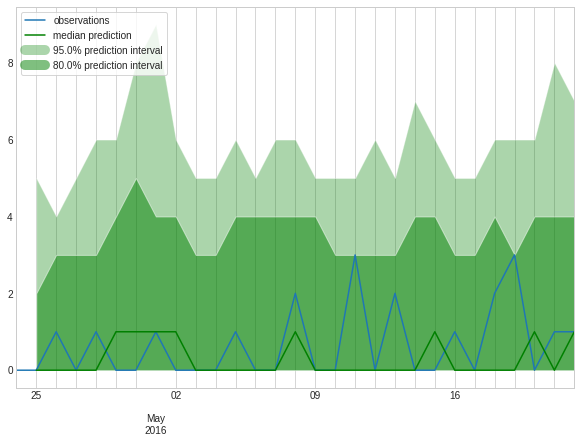

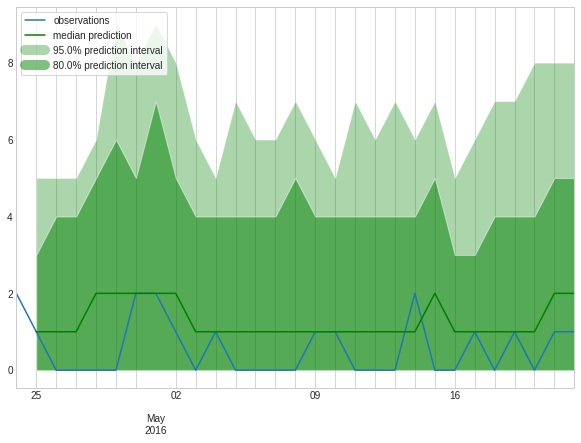

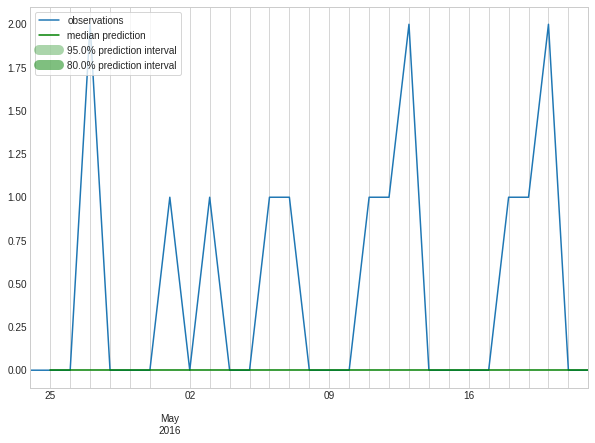

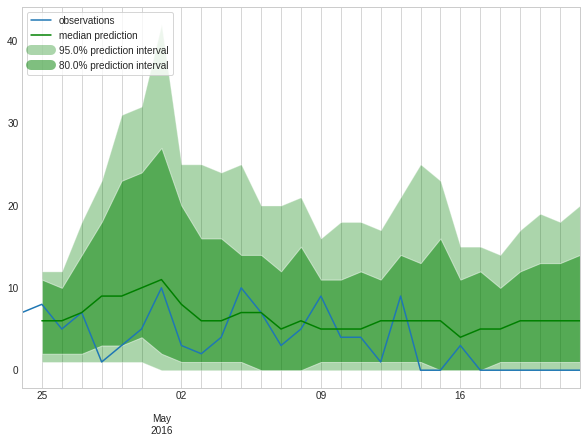

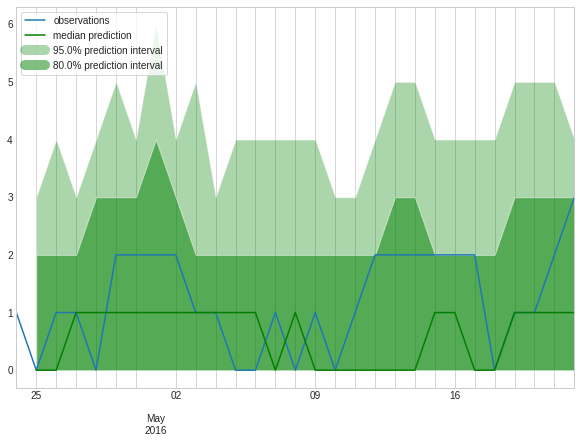

In [20]:
for i in range(5):
    ts_entry = tss[i]
    forecast_entry = forecasts[i]
    plot_prob_forecasts(ts_entry, forecast_entry)

***какие-то выводы***

Посчитаем метрику.

In [21]:
def get_scores(forecasts, aggr_func=np.median):
    forecast_sells = np.asarray(
        [aggr_func(frcst.samples, axis=0) for frcst in forecasts]
    ) # прогнозируемое по аггрегации
    
    return forecast_sells

In [22]:
train_sells = df_train.to_numpy()
valid_sells = df_valid.to_numpy()[:, 1:] # Реальные данные

# Считаем по медиане
forecast_sells = get_scores(forecasts, np.median)
assert forecast_sells.shape == valid_sells.shape

## Подсчет метрики

Веса для каждого ряда определяются по **обучающей** выборке для последних 28 дней: число проданных товаров за день помноженное на цену, по которой в этот день товар продавался. По сути просто выручка. Руководствуюсь здесь официальном [гайдом](https://github.com/Mcompetitions/M5-methods/blob/master/M5-Competitors-Guide.pdf).

Как я понял, дальше веса нормируются самым простым образом (никакого софтмакса и т.д.).

Делаю здесь не в точности как в [соревновании](https://www.pmorgan.com.au/tutorials/wrmsse-for-the-m5-dataset/), а с учетом того, что у меня ряды по одному магазину и одной категории.

In [23]:
assert np.all(prices_train.T.columns == df_train.T.columns)
assert np.all(prices_train.T.index == df_train.T.index)

In [24]:
prices_28 = prices_train.T.to_numpy()[-28:]
quantities_28 = df_train.T.to_numpy()[-28:]
train_28_rev = (quantities_28 * prices_28).sum(axis=0)
assert train_28_rev.shape == (1047,)

In [25]:
WEIGHTS = train_28_rev / train_28_rev.sum()
WEIGHTS.sum()

0.9999999999999998

Все. Посчитали.

In [26]:
def rmsse(train_sells, valid_sells, forecast_sells):
    forecast_mse = np.mean((valid_sells - forecast_sells) ** 2, axis=1)
    train_diff = (train_sells[:, 1:] - train_sells[:, :-1]) ** 2
    train_mse = train_diff.mean(axis=1)
    rmsse_vals = np.sqrt(forecast_mse / train_mse)
    return (WEIGHTS * rmsse_vals).sum()

rmsse(train_sells, valid_sells, forecast_sells)

1.2544684711731757

1.2544684711731757

Топовое решение: `0.52043`. Радует, что у меня вышло не самое худшее качество. По сути 2509 место в соревновании из 5558.